In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

In [2]:
df1 = pd.read_csv('../../data/train_validation_marker.csv')

In [3]:
df1.columns

Index(['Encoded_SKU_ID', 'SALES_DATE', 'SUBCLASS_NAME', 'CLASS_NAME',
       'ML_NAME', 'CATEGORY_NAME', 'RETAIL_PRICE', 'PROMO_PRICE',
       'COMPETITOR_PRICE', 'Inventory', 'DAILY_UNITS', 'max_SALES_DATE',
       'delta_days', 'validation', 'validation_clean'],
      dtype='object')

In [4]:
df1.head()

,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS,max_SALES_DATE,delta_days,validation,validation_clean
0,1,2017-09-28,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,1,2022-07-31,1767,False,True
1,2,2017-11-24,CAMERA BATTERIES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,39.99,?,?,Fully-Stocked,18,2022-07-31,1710,False,True
2,3,2019-11-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,46.98,Constrained,7,2022-07-31,976,False,True
3,4,2021-04-21,SO RANGEHOODS REG,KITCHEN VENTILATION,ML - Kitchen,VP - Major Appliances,549.99,?,498,Fully-Stocked,6,2022-07-31,466,False,False
4,1,2018-10-27,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,7,2022-07-31,1373,False,True


## Use SKU1 as an example:

In [78]:
sku_1_val = df1[(df1['Encoded_SKU_ID']==4) & (df1['validation'] == True)][['Encoded_SKU_ID','SALES_DATE','DAILY_UNITS']]
sku_1_train = df1[(df1['Encoded_SKU_ID']==4) & (df1['validation'] == False)][['Encoded_SKU_ID','SALES_DATE','DAILY_UNITS']]

In [79]:
sku_1_train['SALES_DATE'] = pd.to_datetime(sku_1_train['SALES_DATE'])
sku_1_val['SALES_DATE'] = pd.to_datetime(sku_1_val['SALES_DATE'])

In [80]:
sku_1_train.set_index('SALES_DATE', inplace = True)
sku_1_val.set_index('SALES_DATE', inplace = True)

/var/folders/mt/bm2h50kj2872xhymzl24djch0000gn/T/ipykernel_12285/3199655763.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  sku_1_train.loc['2022.07.01':]['DAILY_UNITS'].plot()


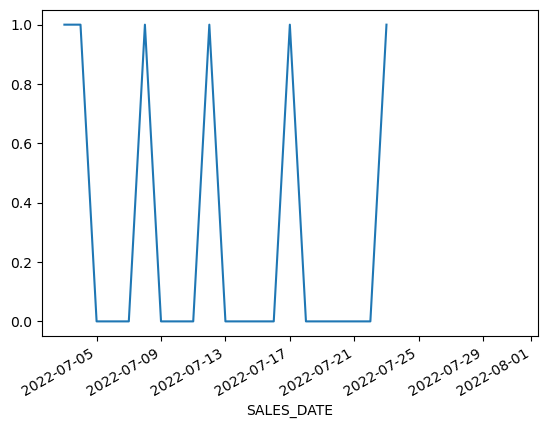

In [81]:
sku_1_train.loc['2022.07.01':]['DAILY_UNITS'].plot()
sku_1_val['DAILY_UNITS'].plot()
plt.show()

In [9]:
model = auto_arima(sku_1_train['DAILY_UNITS'], alpha = 0.1)
model.fit(sku_1_train['DAILY_UNITS'])
model

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [10]:
forecast = model.predict(n_periods=7).astype('int')

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [11]:
prediction = pd.DataFrame(forecast,columns=['predicted']).reset_index(drop=True).set_index(sku_1_val.index)

In [12]:
prediction['Encoded_SKU_ID'] = sku_1_val['Encoded_SKU_ID']

In [13]:
prediction.set_index(sku_1_val.index)

,predicted,Encoded_SKU_ID
SALES_DATE,,
2022-07-25,2,1
2022-07-27,2,1
2022-07-29,2,1
2022-07-31,2,1
2022-07-26,2,1
2022-07-28,2,1
2022-07-30,2,1


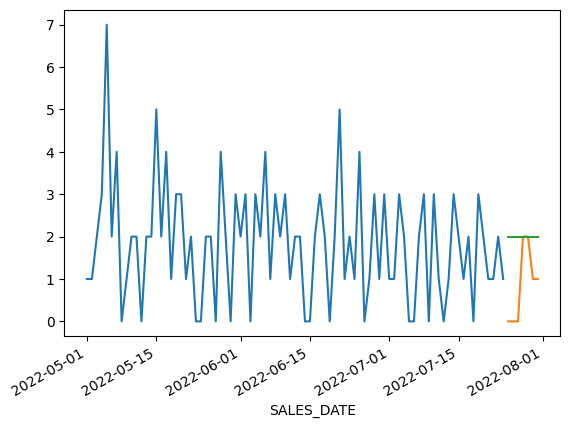

In [14]:
sku_1_train.loc['2022.05.01':]['DAILY_UNITS'].plot()
sku_1_val['DAILY_UNITS'].plot()
prediction['predicted'].plot()
plt.show()

In [15]:
prediction.reset_index(inplace = True)

In [16]:
sku_1_val.reset_index(inplace = True)

In [17]:
sku_1_val.rename(columns={'DAILY_UNITS':'actual'}, inplace = True)

In [18]:
sku_1_val

,SALES_DATE,Encoded_SKU_ID,actual
0,2022-07-25,1,0
1,2022-07-27,1,0
2,2022-07-29,1,2
3,2022-07-31,1,1
4,2022-07-26,1,0
5,2022-07-28,1,2
6,2022-07-30,1,1


In [19]:
import sys

In [20]:
sys.path.append("/Users/yibeihu/bestbuy_project/")

In [21]:
from src.utils import *

In [38]:
prediction.dtypes,sku_1_val.dtypes

(SALES_DATE        datetime64[ns]
 predicted                  int64
 Encoded_SKU_ID             int64
 dtype: object,
 SALES_DATE        datetime64[ns]
 Encoded_SKU_ID             int64
 actual                     int64
 dtype: object)

In [23]:
rmse_sku(sku_1_val,prediction)

,rmse_du,mean_du,pct_rmse
Encoded_SKU_ID,,,
1,1.414214,0.857143,1.649916


## Fit each SKU for prediction and check for overall acurarcy

In [90]:
# Find which are the SKU that have data on 2022.7.31
clean_sku = list(set(df1[df1['validation_clean'] ==True]['Encoded_SKU_ID']))

In [109]:
y_pred = pd.DataFrame()
y_actual = pd.DataFrame()

for i in clean_sku:
    # clean train data on item i
    train = df1[(df1['Encoded_SKU_ID']==i) & (df1['validation'] == False)][['Encoded_SKU_ID','SALES_DATE','DAILY_UNITS']]
    train['SALES_DATE'] = pd.to_datetime(train['SALES_DATE'])
    train.set_index('SALES_DATE', inplace = True)
    
    val = df1[(df1['Encoded_SKU_ID']==i) & (df1['validation'] == True)][['Encoded_SKU_ID','SALES_DATE','DAILY_UNITS']]
    val['SALES_DATE'] = pd.to_datetime(val['SALES_DATE'])
    val.set_index('SALES_DATE', inplace = True)
    
    # train the ARIMA model with auto train & make the forecast
    model = auto_arima(train['DAILY_UNITS'], alpha = 0.1)
    model.fit(train['DAILY_UNITS'])
    forecast = model.predict(n_periods=7).astype('int')
    
    #Construct the predicted dataframe
    prediction = pd.DataFrame(forecast,columns=['predicted']).reset_index(drop=True).set_index(val.index)
    prediction['Encoded_SKU_ID'] = val['Encoded_SKU_ID']
    prediction.reset_index(inplace = True)
    y_pred = pd.concat([y_pred, prediction], axis = 0)
    
    #Construct the actual dataframe
    val.reset_index(inplace = True)
    val.rename(columns={'DAILY_UNITS':'actual'}, inplace = True)
    y_actual = pd.concat([y_actual, val], axis = 0)

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

In [110]:
y_pred,y_actual

(   SALES_DATE  predicted  Encoded_SKU_ID
 0  2022-07-25          2               1
 1  2022-07-27          2               1
 2  2022-07-29          2               1
 3  2022-07-31          2               1
 4  2022-07-26          2               1
 ..        ...        ...             ...
 2  2022-07-28          9             575
 3  2022-07-30          9             575
 4  2022-07-25          9             575
 5  2022-07-27          9             575
 6  2022-07-29          9             575
 
 [3815 rows x 3 columns],
    SALES_DATE  Encoded_SKU_ID  actual
 0  2022-07-25               1       0
 1  2022-07-27               1       0
 2  2022-07-29               1       2
 3  2022-07-31               1       1
 4  2022-07-26               1       0
 ..        ...             ...     ...
 2  2022-07-28             575       0
 3  2022-07-30             575       2
 4  2022-07-25             575       0
 5  2022-07-27             575       0
 6  2022-07-29             575       2


In [112]:
rmse_sku(y_actual,y_pred)

,rmse_du,mean_du,pct_rmse
Encoded_SKU_ID,,,
97,1027.285814,0.714286,1438.200139
237,433.768536,4.142857,104.702750
347,204.446640,3.571429,57.245059
469,141.124565,450.857143,0.313014
557,110.969108,70.571429,1.572437
...,...,...,...
560,0.534522,1.000000,0.534522
386,0.534522,0.714286,0.748331
245,0.534522,0.714286,0.748331


In [114]:
rmse(y_actual,y_pred)

50.24196498816064

In [139]:
y_pred_005 = pd.DataFrame()
y_actual_005 = pd.DataFrame()

for i in clean_sku:
    # clean train data on item i
    train = df1[(df1['Encoded_SKU_ID']==i) & (df1['validation'] == False)][['Encoded_SKU_ID','SALES_DATE','DAILY_UNITS']]
    train['SALES_DATE'] = pd.to_datetime(train['SALES_DATE'])
    train.set_index('SALES_DATE', inplace = True)
    
    val = df1[(df1['Encoded_SKU_ID']==i) & (df1['validation'] == True)][['Encoded_SKU_ID','SALES_DATE','DAILY_UNITS']]
    val['SALES_DATE'] = pd.to_datetime(val['SALES_DATE'])
    val.set_index('SALES_DATE', inplace = True)
    
    # train the ARIMA model with auto train & make the forecast
    model = auto_arima(train['DAILY_UNITS'], alpha = 0.05)
    model.fit(train['DAILY_UNITS'])
    forecast = model.predict(n_periods=7).astype('int')
    
    #Construct the predicted dataframe
    prediction = pd.DataFrame(forecast,columns=['predicted']).reset_index(drop=True).set_index(val.index)
    prediction['Encoded_SKU_ID'] = val['Encoded_SKU_ID']
    prediction.reset_index(inplace = True)
    y_pred_005 = pd.concat([y_pred_005, prediction], axis = 0)
    
    #Construct the actual dataframe
    val.reset_index(inplace = True)
    val.rename(columns={'DAILY_UNITS':'actual'}, inplace = True)
    y_actual_005 = pd.concat([y_actual_005, val], axis = 0)

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

In [140]:
y_actual_005.shape, y_pred_005.shape

((3815, 3), (3815, 3))

In [143]:
rmse(y_actual_005, y_pred_005)

50.24179281972826

# See ARIMA's performance for low variance/high variance data

In [168]:
unit_freq = df1[df1['validation_clean']== True].groupby('Encoded_SKU_ID',as_index= False)['DAILY_UNITS'].nunique()

In [169]:
unit_freq.head()

,Encoded_SKU_ID,DAILY_UNITS
0,1,11
1,2,46
2,3,19
3,5,20
4,6,39


In [170]:
unit_freq['DAILY_UNITS'].median(),unit_freq['DAILY_UNITS'].mean()

(22.0, 38.73577981651376)

Therefore, the distribution of daily sale units of an item is skewed to the right.

<AxesSubplot: >

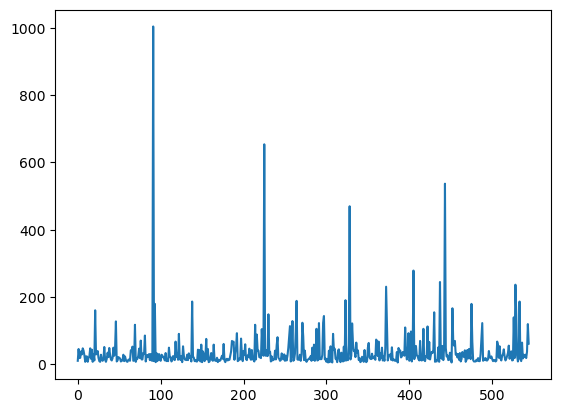

In [171]:
unit_freq['DAILY_UNITS'].plot()

In [172]:
hig_var_sku = unit_freq[unit_freq['DAILY_UNITS']>39]['Encoded_SKU_ID']

In [173]:
def fit_arima(sku,df1,alpha=0.05):
    y_pred = pd.DataFrame()
    y_actual = pd.DataFrame()

    for i in sku:
    # clean train data on item i
        train = df1[(df1['Encoded_SKU_ID']==i) & (df1['validation'] == False)][['Encoded_SKU_ID','SALES_DATE','DAILY_UNITS']]
        train['SALES_DATE'] = pd.to_datetime(train['SALES_DATE'])
        train.set_index('SALES_DATE', inplace = True)
    
        val = df1[(df1['Encoded_SKU_ID']==i) & (df1['validation'] == True)][['Encoded_SKU_ID','SALES_DATE','DAILY_UNITS']]
        val['SALES_DATE'] = pd.to_datetime(val['SALES_DATE'])
        val.set_index('SALES_DATE', inplace = True)
    
    # train the ARIMA model with auto train & make the forecast
        model = auto_arima(train['DAILY_UNITS'], alpha = alpha)
        model.fit(train['DAILY_UNITS'])
        forecast = model.predict(n_periods=7).astype('int')
    
    #Construct the predicted dataframe
        prediction = pd.DataFrame(forecast,columns=['predicted']).reset_index(drop=True).set_index(val.index)
        prediction['Encoded_SKU_ID'] = val['Encoded_SKU_ID']
        prediction.reset_index(inplace = True)
        y_pred = pd.concat([y_pred, prediction], axis = 0)
    
    #Construct the actual dataframe
        val.reset_index(inplace = True)
        val.rename(columns={'DAILY_UNITS':'actual'}, inplace = True)
        y_actual = pd.concat([y_actual, val], axis = 0)
        
    return(y_pred,y_actual)

In [174]:
y_pred_var,y_actual_var = fit_arima(hig_var_sku,df1,alpha=0.05)

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

In [177]:
rmse(y_pred_var,y_actual_var)

98.31381713593991

In [179]:
low_var_sku = unit_freq[unit_freq['DAILY_UNITS']<22]['Encoded_SKU_ID']

In [182]:
y_pred_low_var,y_actual_low_var = fit_arima(low_var_sku,df1,alpha=0.05)

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yibeihu/opt/anaconda3/envs/bestbuy_project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

In [183]:
rmse(y_pred_low_var,y_actual_low_var)

1.4810345584101205